#**Long Short-Term Memory (LSTM) Recurrent Neural Network for Low-Flow Hydrological Time Series Forecasting**

**Reproduction et adaptation de l’étude :**  
*Sahoo et al. (2019), Acta Geophysica*

## Contexte

La prévision des séries temporelles hydrologiques, en particulier des **débits faibles (low-flow)**,
constitue un enjeu majeur pour la gestion durable des ressources en eau, la planification
hydraulique et la préservation des écosystèmes aquatiques.

Les méthodes statistiques classiques présentent des limites face à la **non-linéarité** et aux
**dépendances temporelles longues** caractéristiques des processus hydrologiques.
Les réseaux de neurones récurrents, et en particulier les **Long Short-Term Memory (LSTM)**,
offrent une alternative prometteuse grâce à leurs mécanismes de mémoire interne.


## Objectifs

Les objectifs principaux de ce travail sont :

- Implémenter un modèle **LSTM many-to-one** pour la prévision du low-flow mensuel.
- Reproduire la méthodologie proposée par **Sahoo et al. (2019)** sur un dataset hydrologique réel.
- Comparer les performances du LSTM avec :
  - un **RNN classique**
  - une **méthode naïve saisonnière** (benchmark).
- Évaluer les modèles à l’aide des métriques :
  **RMSE, MAE, coefficient de corrélation (R) et Nash–Sutcliffe Efficiency (ENS)**.


## Description du dataset

Le dataset utilisé contient des **données de débit journalier** mesurées à une station hydrologique.
Les données brutes sont pré-traitées selon les étapes suivantes :

- Sélection de la variable **Discharge** (débit journalier).
- Agrégation mensuelle et calcul du **low-flow Q75**.
- Transformation logarithmique pour stabiliser la variance.
- Normalisation des données.
- Construction de séquences temporelles avec un **lag de 12 mois**.

Ce pré-traitement est conforme à la méthodologie décrite dans l’article de référence.


# **Partie 1 : Prétraitement des données**

**Importations**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files


**Import du dataset**

In [36]:
uploaded = files.upload()


Saving runoff.csv to runoff (2).csv


In [37]:
df = pd.read_csv(list(uploaded.keys())[0])


In [38]:
# Verification du dataset
df.head()


,Date,Discharge,flood runoff,daily runoff,weekly runoff,FloodOrig,Flood
0,1-Jan-98,8567.0,0.0,1.46,NaN,0.0,0
1,2-Jan-98,12789.0,0.0,2.18,NaN,0.0,0
2,3-Jan-98,11278.0,0.0,1.92,NaN,0.0,0
3,4-Jan-98,11547.0,0.0,1.97,NaN,0.0,0
4,5-Jan-98,12109.0,0.0,2.07,NaN,0.0,0


**Nettoyage strict**

In [39]:
# On ne garde que la colonne date et discharge (Important pour LSTM-RNN)
df = df[['Date', 'Discharge']].copy()



In [40]:
#Conversion de la date
df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
df = df.sort_values('Date').reset_index(drop=True)

/tmp/ipython-input-1319150943.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


In [41]:
#Suppression valeurs manquantes / invalides
df = df[df['Discharge'] > 0]
df = df.dropna()


**Visualisation du débit journalier**

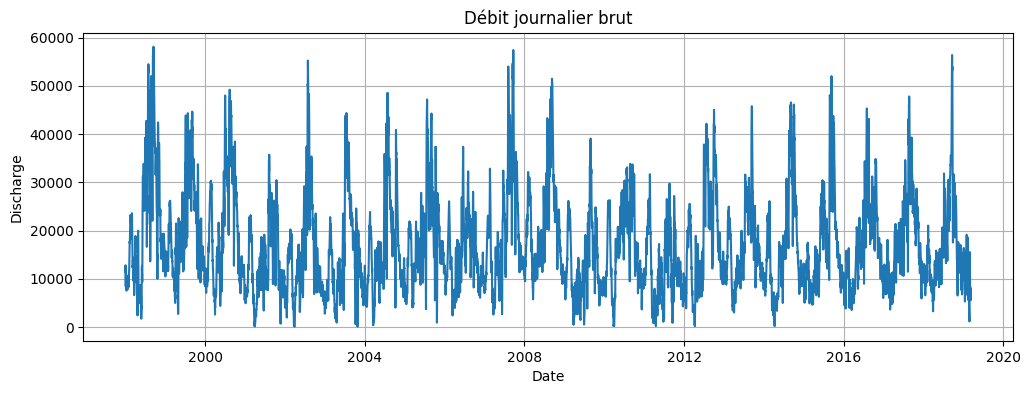

In [42]:
plt.figure(figsize=(12,4))
plt.plot(df['Date'], df['Discharge'])
plt.title("Débit journalier brut")
plt.xlabel("Date")
plt.ylabel("Discharge")
plt.grid(True)
plt.show()


**Calcul du low-flow Q75 (journalier)**

In [43]:
Q75_threshold = np.percentile(df['Discharge'], 75)
Q75_threshold


np.float64(22565.0)

In [44]:
#Filtrage low-flow
df['YearMonth'] = df['Date'].dt.to_period('M')

monthly_Q75 = (
    df.groupby('YearMonth')['Discharge']
      .quantile(0.75)
      .reset_index()
)

monthly_Q75['Date'] = monthly_Q75['YearMonth'].dt.to_timestamp()
monthly_Q75 = monthly_Q75[['Date', 'Discharge']]
monthly_Q75.rename(columns={'Discharge': 'Q75'}, inplace=True)



**Agrégation mensuelle (Q75 mensuel)**

In [45]:
from sklearn.preprocessing import MinMaxScaler

monthly_Q75['Q75_log'] = np.log(monthly_Q75['Q75'])

scaler = MinMaxScaler(feature_range=(0,1))
monthly_Q75['Q75_scaled'] = scaler.fit_transform(
    monthly_Q75[['Q75_log']]
)


**Visualisation du low-flow mensuel**

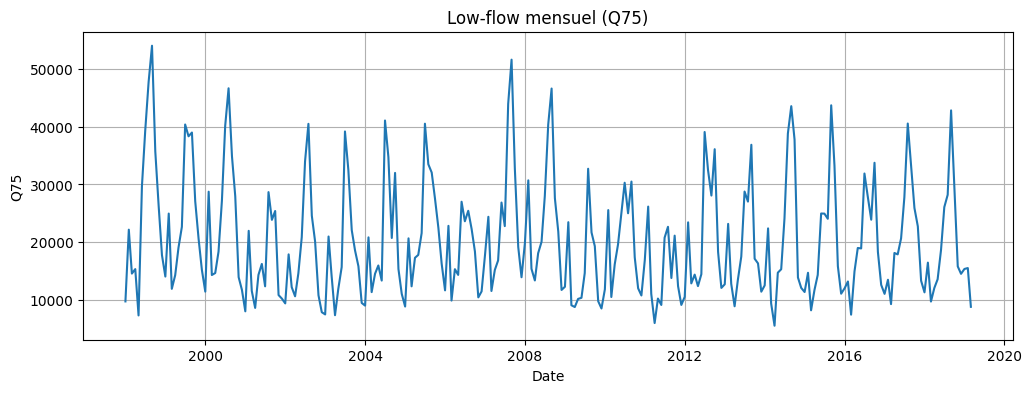

In [46]:
plt.figure(figsize=(12,4))
plt.plot(monthly_Q75['Date'], monthly_Q75['Q75'])
plt.title("Low-flow mensuel (Q75)")
plt.xlabel("Date")
plt.ylabel("Q75")
plt.grid(True)
plt.show()


**Log-transformation**

In [47]:
#verification
monthly_Q75.head()


,Date,Q75,Q75_log,Q75_scaled
0,1998-01-01,9740.00,9.183996,0.248151
1,1998-02-01,22163.00,10.006180,0.609047
2,1998-03-01,14560.00,9.586033,0.424625
3,1998-04-01,15335.75,9.637942,0.447410
4,1998-05-01,7315.00,8.897682,0.122474


**Création des séquences temporelles (lag = 12)**

In [48]:
series = monthly_Q75['Q75_scaled'].values

def create_sequences(series, lag=12):
    X, y = [], []
    for i in range(lag, len(series)):
        X.append(series[i-lag:i])
        y.append(series[i])
    return np.array(X), np.array(y)

X, y = create_sequences(series, lag=12)
X = X.reshape((X.shape[0], X.shape[1], 1))


In [49]:
#Vérification des dimensions
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (243, 12, 1)
y shape: (243,)


In [50]:
#Découpage train / val / test
n = len(X)

train_end = int(0.70 * n)
val_end   = int(0.85 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val,   y_val   = X[train_end:val_end], y[train_end:val_end]
X_test,  y_test  = X[val_end:], y[val_end:]


In [51]:
#verification
print("Train:", X_train.shape)
print("Val  :", X_val.shape)
print("Test :", X_test.shape)


Train: (170, 12, 1)
Val  : (36, 12, 1)
Test : (37, 12, 1)


# **Partie 2 : Implementation des modèles**

In [52]:
# Activation et verification du GPU
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("GPU available:", tf.config.list_physical_devices('GPU'))


TensorFlow version: 2.19.0
GPU available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [53]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, SimpleRNN, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error, mean_absolute_error


**Fonctions de métriques**

In [54]:
def RMSE(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def MAE(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def R_coeff(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

def ENS(y_true, y_pred):
    return 1 - np.sum((y_true - y_pred)**2) / np.sum((y_true - np.mean(y_true))**2)


**Modèle LSTM (many-to-one)**

In [55]:
from tensorflow.keras.layers import Dropout

lstm_model = Sequential([
    LSTM(32, return_sequences=True, input_shape=(12,1)),
    Dropout(0.2),
    LSTM(16),
    Dense(1)
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


**Entraînement**

In [56]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',
    patience=50,
    restore_best_weights=True
)

history = lstm_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=1000,
    batch_size=16,
    callbacks=[early_stop],
    verbose=0
)


In [57]:
y_pred_scaled = lstm_model.predict(X_test).flatten()

y_pred_log = scaler.inverse_transform(
    y_pred_scaled.reshape(-1,1)
).flatten()

y_pred = np.exp(y_pred_log)

y_true_log = scaler.inverse_transform(
    y_test.reshape(-1,1)
).flatten()

y_true = np.exp(y_true_log)


1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step


**Modèle RNN classique**

In [58]:
rnn_model = Sequential([
    SimpleRNN(5, input_shape=(X_train.shape[1], 1)),
    Dense(1)
])

rnn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse'
)

rnn_model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)        │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [59]:
history_rnn = rnn_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=2000,
    batch_size=32,
    verbose=0
)


**Prédictions (back-transform log → réel)**

In [60]:
# LSTM
y_pred_lstm = np.exp(lstm_model.predict(X_test).flatten())
y_true = np.exp(y_test)

# RNN
y_pred_rnn = np.exp(rnn_model.predict(X_test).flatten())


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step


**Méthode naïve saisonnière**

In [61]:
q75_series = monthly_Q75['Q75'].values

naive_preds = []
naive_true  = []

for i in range(12, len(q75_series)):
    naive_preds.append(q75_series[i-12])
    naive_true.append(q75_series[i])

naive_preds = np.array(naive_preds)
naive_true  = np.array(naive_true)

# Alignement avec le test set
naive_preds = naive_preds[-len(y_true):]
naive_true  = naive_true[-len(y_true):]


**Calcul des métriques**

In [62]:
results = pd.DataFrame({
    'Model': ['LSTM', 'RNN', 'Naïve'],
    'RMSE': [
        RMSE(y_true, y_pred_lstm),
        RMSE(y_true, y_pred_rnn),
        RMSE(naive_true, naive_preds)
    ],
    'MAE': [
        MAE(y_true, y_pred_lstm),
        MAE(y_true, y_pred_rnn),
        MAE(naive_true, naive_preds)
    ],
    'R': [
        R_coeff(y_true, y_pred_lstm),
        R_coeff(y_true, y_pred_rnn),
        R_coeff(naive_true, naive_preds)
    ],
    'ENS': [
        ENS(y_true, y_pred_lstm),
        ENS(y_true, y_pred_rnn),
        ENS(naive_true, naive_preds)
    ]
})

results


,Model,RMSE,MAE,R,ENS
0,LSTM,0.156954,0.125055,0.879886,0.772984
1,RNN,0.176235,0.141952,0.846425,0.713783
2,Naïve,5915.993877,4197.959459,0.782516,0.547660


**Visualisation temporelle**

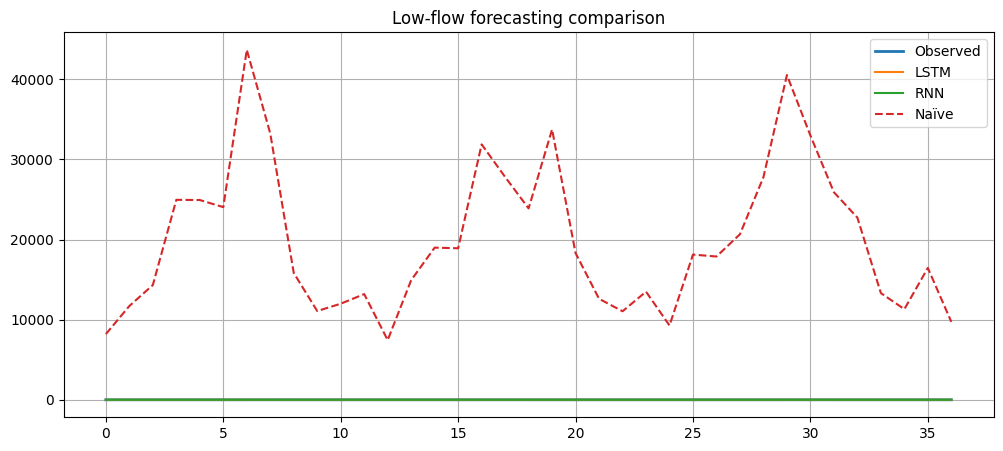

In [63]:
plt.figure(figsize=(12,5))
plt.plot(y_true, label='Observed', linewidth=2)
plt.plot(y_pred_lstm, label='LSTM')
plt.plot(y_pred_rnn, label='RNN')
plt.plot(naive_preds, label='Naïve', linestyle='--')
plt.legend()
plt.title("Low-flow forecasting comparison")
plt.grid(True)
plt.show()


**Scatterplots**

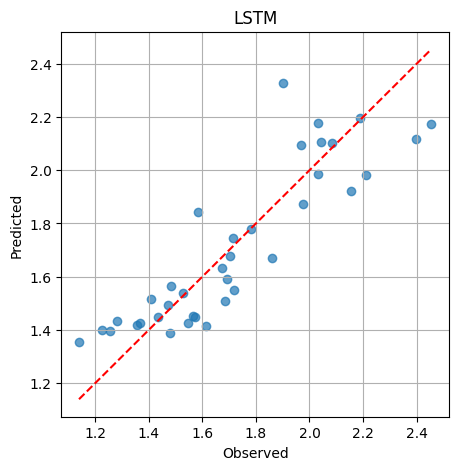

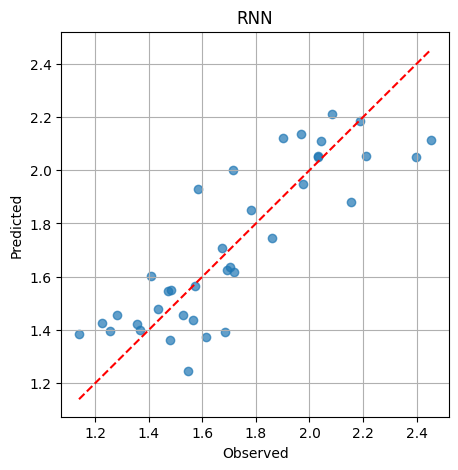

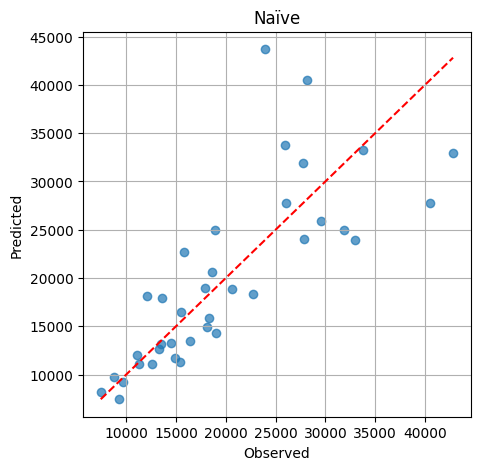

In [64]:
def scatter_plot(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.7)
    plt.plot([y_true.min(), y_true.max()],
             [y_true.min(), y_true.max()], 'r--')
    plt.xlabel("Observed")
    plt.ylabel("Predicted")
    plt.title(title)
    plt.grid(True)
    plt.show()

scatter_plot(y_true, y_pred_lstm, "LSTM")
scatter_plot(y_true, y_pred_rnn,  "RNN")
scatter_plot(naive_true, naive_preds, "Naïve")
